## In this notebook: 

## Contig assigned to which taxon? What AMR genes are detected on this contig?

In [7]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import pylab
from glob import glob

In [6]:
# set directory
os.chdir('Greywater_Metagemonics/Greywater_Data/')

In [9]:
# sample names
sample_id = ["house_1_raw", "house_1_treat",
             "house_2_raw", "house_2_treat",
             "house_3_raw", "house_3_treat",
             "house_4_raw", "house_4_treat",
             "house_5_raw", "house_5_treat" #, 
            #"raw_greywater_merged"
            ]

## RGI main: detect AMR genes on contigs

### Cleaning and viewing output from RGI main (using contigs or scaffolds)

### When using metaspades output, scaffolds.fasta is the RGI main input file

In [4]:
# loop for all samples
for sample in sample_id:
    print(f"Processing sample {sample}.")
    RGI_out = f"ARGs/contig-RGI/metaspades/{sample}.txt"
    Blobology_out = f"Assembly/blobology/{sample}_scaffolds.blobplot" # all scaffolds, including unbinned
    df1 = pd.read_csv(RGI_out, delimiter = "\t", index_col = 0)
    df2 = pd.read_csv(Blobology_out, delimiter = "\t", index_col = 0)
    print(f"{df2.shape[0]} scaffolds in sample {sample}.")
    print(f"There are {df1.shape[0]} AMR gene detected.")
    # get contig ID for RGI output file
    contig_list = ["_".join(name.split("_")[:-1]) for name in list(df1["Contig"])]
    print(f"AMR genes found in {len(set(contig_list))} contigs.")
    
    df1["Contig_ID"] = contig_list
    # filter out best identities < 95%
    contig_ARG = df1.set_index("Contig_ID")
    contig_ARG = contig_ARG[contig_ARG["Best_Identities"] >= 95.0]
    contig_ARG = contig_ARG[contig_ARG["Best_Hit_Bitscore"] >= 50]
    
    # get list of contigs in common
    common_list = [contig for contig in list(df2.index) if contig in list(contig_ARG.index)]
    print(f"{len(common_list)} contigs contain AMR genes.")
    
    contig_ARG = contig_ARG.loc[common_list, ["Best_Hit_ARO","Resistance Mechanism", "AMR Gene Family", "Drug Class"]]
    taxon_ARG = contig_ARG.assign(Species = df2.loc[contig_ARG.index, "taxlevel_species"], Bin = df2.loc[contig_ARG.index, "bin"])
    taxon_ARG_species = taxon_ARG[taxon_ARG["Species"] != "Not annotated"]
    
    # save to csv
    taxon_ARG.to_csv(f"Assembly/metaspades_cooccurrence/{sample}_scaffolds_AMR_95_cutoff.csv", sep = ",")
    taxon_ARG_species.to_csv(f"Assembly/metaspades_cooccurrence/{sample}_species_AMR_95_cutoff.csv", sep = ",")
    print(f"{taxon_ARG.shape[0]} co-occurrence of taxa and ARGs. \n")

Processing sample house_1_raw.
388030 scaffolds in sample house_1_raw.
There are 494 AMR gene detected.
AMR genes found in 484 contigs.
54 contigs contain AMR genes.
57 co-occurrence of taxa and ARGs. 

Processing sample house_1_treat.
4189397 scaffolds in sample house_1_treat.
There are 4446 AMR gene detected.
AMR genes found in 4345 contigs.
47 contigs contain AMR genes.
47 co-occurrence of taxa and ARGs. 

Processing sample house_2_raw.
2405591 scaffolds in sample house_2_raw.
There are 2447 AMR gene detected.
AMR genes found in 2421 contigs.
161 contigs contain AMR genes.
162 co-occurrence of taxa and ARGs. 

Processing sample house_2_treat.
3886670 scaffolds in sample house_2_treat.
There are 3998 AMR gene detected.
AMR genes found in 3967 contigs.
86 contigs contain AMR genes.
90 co-occurrence of taxa and ARGs. 

Processing sample house_3_raw.
509642 scaffolds in sample house_3_raw.
There are 765 AMR gene detected.
AMR genes found in 759 contigs.
97 contigs contain AMR genes.
103

### Concat raw greywater samples and treated greywater samples output

In [18]:
raw_sample_names = glob("Assembly/metaspades_cooccurrence/house_*_raw_species_AMR_95_cutoff.csv")

raw_sum = None

for sample in raw_sample_names:
    raw = pd.read_csv(sample, delimiter = ",", index_col = 0)
    if raw_sum is None:
        raw_sum = raw
    else:
        raw_sum = pd.concat([raw_sum,raw])

In [19]:
raw_sum.shape

(547, 6)

In [20]:
treat_sample_names = glob("Assembly/metaspades_cooccurrence/house_*_treat_species_AMR_95_cutoff.csv")

treat_sum = None

for sample in treat_sample_names:
    treat = pd.read_csv(sample, delimiter = ",", index_col = 0)
    if treat_sum is None:
        treat_sum = treat
    else:
        treat_sum = pd.concat([treat_sum,treat])

In [21]:
treat_sum.shape

(269, 6)

In [22]:
raw_sum.to_csv("Assembly/metaspades_cooccurrence/raw_sum_species_AMR_95_cutoff.csv", sep = ",")
treat_sum.to_csv("Assembly/metaspades_cooccurrence/treat_sum_species_AMR_95_cutoff.csv", sep = ",")

### Prepare txt files for venn diagram for unique ARGs

In [23]:
# For individual samples
for sample in sample_id: # loop for all samples in sample_id
    print(f"Processing sample {sample}.")
# Assign ARG_df from RGI output file RGI_out
    RGI_out = f"Assembly/metaspades_cooccurrence/{sample}_scaffolds_AMR_95_cutoff.csv"
    ARG_df = pd.read_csv(RGI_out, delimiter = ",", index_col =0)
# Make list of unique ARO terms
    ARG_list = list(ARG_df["Best_Hit_ARO"].unique())
# Write to a txt file
    with open(f"ARGs/contig-RGI/metaspades/{sample}_ARGs_95_50_cutoff.txt", "w") as f:
        for row in ARG_list:
            f.write(row+"\n")

Processing sample house_1_raw.
Processing sample house_1_treat.
Processing sample house_2_raw.
Processing sample house_2_treat.
Processing sample house_3_raw.
Processing sample house_3_treat.
Processing sample house_4_raw.
Processing sample house_4_treat.
Processing sample house_5_raw.
Processing sample house_5_treat.
Processing sample raw_greywater_merged.


In [24]:
# For raw and treated samples sum
raw_sum = None
treated_sum = None
for i in [0,2,4,6,8]: # loop for all raw samples in sample_id
# Assign ARG_df from RGI output file RGI_out
    #print(f"{sample_id[i]}")
    RGI_out = f"Assembly/metaspades_cooccurrence/{sample_id[i]}_scaffolds_AMR_95_cutoff.csv"
    ARG_df = pd.read_csv(RGI_out, delimiter = ",", index_col =0)
    raw_sum = pd.concat([raw_sum,ARG_df])
# Make list of unique ARO terms
ARG_list = list(raw_sum["Best_Hit_ARO"].unique())
# Write to a txt file
with open(f"ARGs/contig-RGI/metaspades/raw_sum_ARGs_95_50_cutoff.txt", "w") as f:
    for row in ARG_list:
        f.write(row+"\n")

for i in [1,3,5,7,9]: # loop for all treated samples in sample_id
# Assign ARG_df from RGI output file RGI_out
    #print(f"{sample_id[i]}")
    RGI_out = f"Assembly/metaspades_cooccurrence/{sample_id[i]}_scaffolds_AMR_95_cutoff.csv"
    ARG_df = pd.read_csv(RGI_out, delimiter = ",", index_col =0)
    treated_sum = pd.concat([treated_sum,ARG_df])

# Make list of unique ARO terms
ARG_list = list(treated_sum["Best_Hit_ARO"].unique())
# Write to a txt file
with open(f"ARGs/contig-RGI/metaspades/treated_sum_ARGs_95_50_cutoff.txt", "w") as f:
    for row in ARG_list:
        f.write(row+"\n")

### ARG genes counts by gene family/Resistance Mechanism/Drug Class and plot

In [9]:
DC_df = None
GF_df = None
RM_df = None

for sample in sample_id: # loop for all samples in sample_id
    print(f"Processing sample {sample}.")
# Assign ARG_df from RGI output file RGI_out
    RGI_out = f"Assembly/metaspades_cooccurrence/{sample}_scaffolds_AMR_95_cutoff.csv"
    ARG_df = pd.read_csv(RGI_out, delimiter = ",", index_col =0)
    ARG_df = ARG_df.groupby(by = ['Best_Hit_ARO']).first()
    #print(ARG_df.head())
    ARG_df[f'{sample}'] = 1
    ARG_GF = ARG_df.groupby(by = ['AMR Gene Family']).sum()[[f'{sample}']]
    ARG_RM = ARG_df.groupby(by = ['Resistance Mechanism']).sum()[[f'{sample}']]
    ARG_DC = ARG_df.groupby(by = ['Drug Class']).sum()[[f'{sample}']]
    if DC_df is None:
        DC_df = ARG_DC
    else:
        DC_df = DC_df.join(ARG_DC, how='outer')
    
    if GF_df is None:
        GF_df = ARG_GF
    else:
        GF_df = GF_df.join(ARG_GF, how='outer')
    
    if RM_df is None:
        RM_df = ARG_RM
    else:
        RM_df = RM_df.join(ARG_RM, how='outer')

Processing sample house_1_raw.
Processing sample house_1_treat.
Processing sample house_2_raw.
Processing sample house_2_treat.
Processing sample house_3_raw.
Processing sample house_3_treat.
Processing sample house_4_raw.
Processing sample house_4_treat.
Processing sample house_5_raw.
Processing sample house_5_treat.
Processing sample raw_greywater_merged.


In [10]:
GF_df.to_csv('ARGs/contig-RGI/metaspades/All_sample_ARGs_count_95_cutoff_by_GF.csv')
RM_df.to_csv('ARGs/contig-RGI/metaspades/All_sample_ARGs_count_95_cutoff_by_RM.csv')
DC_df.to_csv('ARGs/contig-RGI/metaspades/All_sample_ARGs_count_95_cutoff_by_DC.csv')

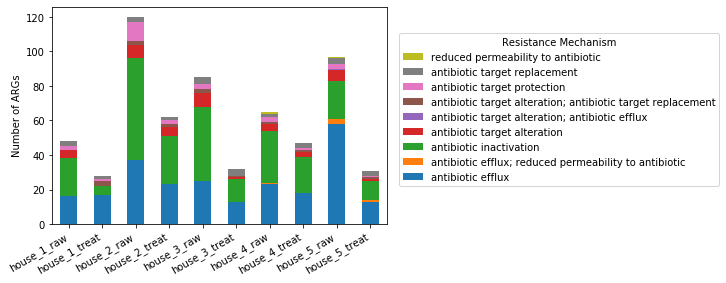

In [13]:
# Bar plot
ax = RM_df.drop(columns=['raw_greywater_merged']).transpose().plot.bar(stacked = True)
plt.xticks(rotation=30, horizontalalignment="right")
# reverse legend labels, set legend outside the plot.
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels),bbox_to_anchor=(1.02, 0.9), 
          title = "Resistance Mechanism")
plt.ylabel("Number of ARGs")
# save the plot
plt.savefig('ARGs/figures/RGI_main_ARG_numbers_by_RM_95cutoff.pdf',bbox_inches='tight')

In [4]:
arg_counts = 'ARGs/contig-RGI/metaspades/ARO_count_summary_strict.csv'
arg_summary = pd.read_csv(arg_counts, index_col = 0)
arg_summary.head()

,AMR Gene Family,Drug Class,Resistance Mechanism,house_1_raw,house_1_treat,house_2_raw,house_2_treat,house_3_raw,house_3_treat,house_4_raw,house_4_treat,house_5_raw,house_5_treat
AER-1,AER beta-lactamase,penam,antibiotic inactivation,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CRP,resistance-nodulation-cell division (RND) anti...,macrolide antibiotic; fluoroquinolone antibiot...,antibiotic efflux,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CfxA2,CfxA beta-lactamase,cephamycin,antibiotic inactivation,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
EreA2,macrolide esterase,macrolide antibiotic,antibiotic inactivation,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EreD,macrolide esterase,macrolide antibiotic,antibiotic inactivation,2.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [10]:
sample_id

['house_1_raw',
 'house_1_treat',
 'house_2_raw',
 'house_2_treat',
 'house_3_raw',
 'house_3_treat',
 'house_4_raw',
 'house_4_treat',
 'house_5_raw',
 'house_5_treat']

/Users/shuaishuai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(5, 10)


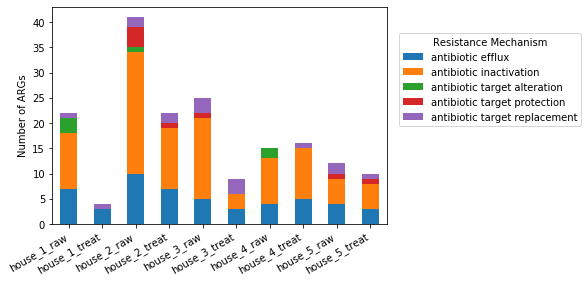

In [12]:
for sample in sample_id:
    arg_summary[sample][arg_summary[sample] != 0] = 1

RM_summary = arg_summary.groupby(by = 'Resistance Mechanism').sum()
print(RM_summary.shape)

plt.rcParams['figure.figsize'] = [6, 4]
ax = RM_summary.transpose().plot.bar(stacked = True)
plt.xticks(rotation=30, horizontalalignment="right")
# reverse legend labels, set legend outside the plot.
handles, labels = ax.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(1.02, 0.9), 
          title = "Resistance Mechanism")
plt.ylabel("Number of ARGs")
# save the plot
plt.savefig('ARGs/figures/RGI_main_ARG_numbers_by_RM_strict.pdf',bbox_inches='tight')